In [1]:
import requests
import pandas as pd
import datetime
import json
from matplotlib import pyplot as plt
from ta import *

In [2]:
start = datetime.datetime(year=2016, month=1, day=1)
start = datetime.datetime.timestamp(start)
start

1451624400.0

In [3]:
def fetch_poloniex_df(currency_pair, start=int(start), end=9999999999, period=14400):
    data = fetch_poloniex(currency_pair, start, end, period)
    df = pd.DataFrame(data)
    df["date"] = df["date"].apply(lambda d: datetime.datetime.utcfromtimestamp(d))
    return df

def fetch_poloniex(currency_pair, start=int(start), end=9999999999, period=14400):
    api = "https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}"
    api = api.format(currency_pair, start, end, period)
    r = requests.get(api)
    return json.loads(r.text)

In [4]:
test = datetime.datetime(year=2018, month=1, day=1)
test = datetime.datetime.timestamp(test)
data = fetch_poloniex("BTC_ETH", start=test, period=14400)
data[0:3]

[{'date': 1514782800,
  'high': 0.05529993,
  'low': 0.05529993,
  'open': 0.05529993,
  'close': 0.05529993,
  'volume': 0,
  'quoteVolume': 0,
  'weightedAverage': 0.05529993},
 {'date': 1514793600,
  'high': 0.0562132,
  'low': 0.0548,
  'open': 0.0552999,
  'close': 0.056,
  'volume': 547.55177592,
  'quoteVolume': 9850.62286967,
  'weightedAverage': 0.05558549},
 {'date': 1514808000,
  'high': 0.057,
  'low': 0.05563538,
  'open': 0.056,
  'close': 0.05644,
  'volume': 908.67088856,
  'quoteVolume': 16102.02785405,
  'weightedAverage': 0.05643207}]

In [8]:
btc_df = fetch_poloniex_df("USDC_BTC", start=test, period=14400)
btc_df["mean"] = (btc_df["high"] + btc_df["low"])/2

btc_df = btc_df.rename(columns={"weightedAverage": "price"})
btc_df.head()

,close,date,high,low,open,quoteVolume,volume,price,mean
0,6481.846675,2018-09-27 12:00:00,6798.000000,6461.066881,6493.658601,0.876761,5701.874517,6503.337433,6629.533441
1,6659.700000,2018-09-27 16:00:00,6676.991255,6483.846675,6483.846675,9.025383,59127.199613,6551.212098,6580.418965
2,6677.567006,2018-09-27 20:00:00,6717.622625,6658.073256,6658.073256,0.997148,6673.005129,6692.093858,6687.847940
3,6690.000000,2018-09-28 00:00:00,6714.553283,6690.000000,6698.021814,4.600176,30886.459109,6714.191311,6702.276641
4,6753.315115,2018-09-28 04:00:00,6775.435948,6690.000000,6691.056128,1.195961,8028.622257,6713.111131,6732.717974


---

C:\Users\Brian\Anaconda3\envs\bitz\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


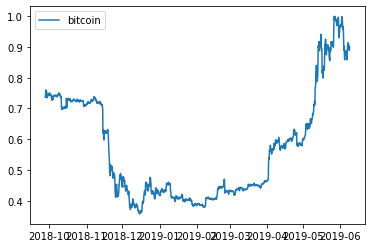

In [10]:
maxVal = btc_df["price"].max()
btc_df["btc_norm"] = btc_df["price"].apply(lambda val: val/maxVal)

plt.plot(btc_df["date"], btc_df["btc_norm"])
plt.legend(["bitcoin"])

plt.show()

---

In [17]:
import importlib
import find_poi
importlib.reload(find_poi)


x = btc_df.index
y = btc_df["price"].copy()

bounds = find_poi.find_poi_df(x, y, window_size=100, threshold=0.05, merge_intervals=True)
len(bounds)

15

In [18]:
bounds[0:3]

[[351, 373, 351, 3629.95012258, 373, 4232.08299377],
 [483, 487, 483, 3204.48850257, 487, 3483.28824618],
 [491, 527, 491, 3452.97462622, 527, 4166.01935443]]

In [19]:
bounds_df = pd.DataFrame(bounds, columns=["start_index", 
                                          "end_index", 
                                          "start_x", "start_y",
                                          "end_x", "end_y"])
bounds_df.head(3)

,start_index,end_index,start_x,start_y,end_x,end_y
0,351,373,351,3629.950123,373,4232.082994
1,483,487,483,3204.488503,487,3483.288246
2,491,527,491,3452.974626,527,4166.019354


In [21]:
bounds_df.min()

start_index     351.000000
end_index       373.000000
start_x         351.000000
start_y        3204.488503
end_x           373.000000
end_y          3483.288246
dtype: float64

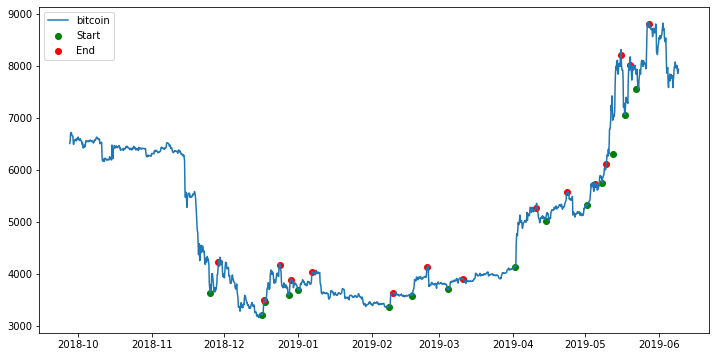

In [29]:


fig = plt.figure(figsize=(12, 6))


plt.plot(btc_df["date"], btc_df["price"], figure=fig)

plt.scatter(btc_df.iloc[bounds_df["start_index"]]["date"], bounds_df["start_y"], color="green")
plt.scatter(btc_df.iloc[bounds_df["end_index"]]["date"], bounds_df["end_y"], color="red")


plt.legend(["bitcoin", "Start", "End"])


plt.show()

---

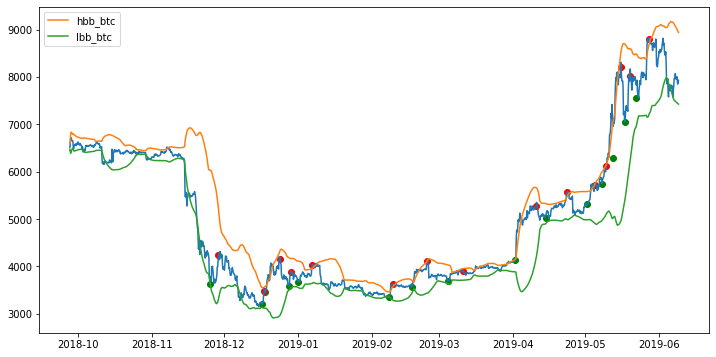

In [32]:
btc_df["btc_bb_high"] = bollinger_hband(btc_df["price"], n=60, ndev=2, fillna=True)
btc_df["btc_bb_low"] = bollinger_lband(btc_df["price"], n=60, ndev=2, fillna=True)


fig = plt.figure(figsize=(12, 6))


plt.plot(btc_df["date"], btc_df["price"], figure=fig)
plt.plot(btc_df["date"], btc_df["btc_bb_high"], label="hbb_btc")
plt.plot(btc_df["date"], btc_df["btc_bb_low"], label="lbb_btc")


plt.scatter(btc_df.iloc[bounds_df["start_index"]]["date"], bounds_df["start_y"], color="green")
plt.scatter(btc_df.iloc[bounds_df["end_index"]]["date"], bounds_df["end_y"], color="red")

plt.legend()




plt.show()

---

# Featuring


btc_df.head(3)